I found a website with some cricket data and thought it would be fun to try and turn it into some ratings. The idea is that this can give a nice indication of the way we work without actually sharing any of our data or real methods.

In [25]:
import utility_functions as util
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import os
import pandas as pd
import pystan
from scipy.special import expit

plt.style.use('sparse.mplstyle')

First we need to get some data - it can be found [here](https://cricsheet.org/downloads/#experimental). 

If you don't have any data already, follow the link above and choose something from the `CSV DOWNLOADS` section - I've gone for the data on male test matches as this is the form of cricket I am most familiar with - and download it to this repository's `data/match_data` folder. Then substitute whatever your folder of csvs is called for `test_csv_male` below and that should be all!

In [2]:
match_ids = []
for filename in os.listdir("../data/match_data/test_csv_male/"):
    if filename.endswith(".csv"):
        match_ids.append(int(filename[:-4]))
        
match_ids = list(np.unique(match_ids))
print("Fount {} matches".format(str(len(match_ids))))
print(match_ids[:5])

Fount 402 test matches
[291352, 291353, 291354, 296900, 296901]


To make sampling a bit quicker, we can choose analyse just a few matches rather than all of them - to analyse all matches just comment out this line.

In [3]:
match_ids = np.random.choice(match_ids, 10)

Next we make a big dataframe featuring all the balls from all the matches we chose.

In [4]:
columns = ['type', 'innings', 'over_and_ball', 'batting_team', 'batter', 'non_striker', 
           'bowler', 'bat_runs', 'extras', 'out']

balls = pd.concat([
    pd.read_csv("~/Downloads/test_csv_male/{0}.csv".format(match_id), names=columns)
    .dropna(subset=['batter'])
    .assign(match_id=match_id)
    for match_id in match_ids
])


balls['bat_runs'] = balls['bat_runs'].astype(int)
balls['extras'] = balls['extras'].astype(int)
balls['out'] = balls['out'].notnull().astype(int)
balls['runs'] = balls['bat_runs'] + balls['extras']

print('Found {0} balls'.format(str(len(balls))))
balls.head()

Found 21641 balls


,type,innings,over_and_ball,batting_team,batter,non_striker,bowler,bat_runs,extras,out,match_id,runs
24,ball,1,0.1,Sri Lanka,FDM Karunaratne,WU Tharanga,Mustafizur Rahman,0,0,0,1083445,0
25,ball,1,0.2,Sri Lanka,FDM Karunaratne,WU Tharanga,Mustafizur Rahman,0,0,0,1083445,0
26,ball,1,0.3,Sri Lanka,FDM Karunaratne,WU Tharanga,Mustafizur Rahman,0,0,0,1083445,0
27,ball,1,0.4,Sri Lanka,FDM Karunaratne,WU Tharanga,Mustafizur Rahman,0,0,0,1083445,0
28,ball,1,0.5,Sri Lanka,FDM Karunaratne,WU Tharanga,Mustafizur Rahman,0,0,0,1083445,0


This dataframe is a bit big. We can compress it while retaining all the information needed for our model by grouping by bowler, batter, and innings, then finding the total number of balls, runs and wickets for each group.

In [5]:
summary = (
    balls.groupby(['bowler', 'batter', 'innings'])
    .agg({'runs': ['sum', 'count'], 'out': 'sum'})
    .pipe(util.flatten_columns)
    .reset_index()
    .rename(columns={'runs_sum': 'runs', 'runs_count': 'balls', 'out_sum': 'wickets'})
    .assign(
        runs=lambda df: df['runs'].astype(int),
        innings=lambda df: df['innings'].astype(int),
        bowler_id=lambda df: util.stanify_series(df['bowler']),
        batter_id=lambda df: util.stanify_series(df['batter'])
    )
)
print('Found {0} bolwer/batter/innings combinations'.format(str(len(summary))))
summary.head()

Found 1016 bolwer/batter/innings combinations


,bowler,batter,innings,runs,balls,wickets,bowler_id,batter_id
0,A Kumble,A Symonds,2,14,15,1,1,1
1,A Kumble,A Symonds,4,7,10,1,1,1
2,A Kumble,AC Gilchrist,2,11,17,0,1,2
3,A Kumble,AC Gilchrist,4,9,13,0,1,2
4,A Kumble,B Lee,2,8,25,0,1,3


Now we compile a Stan model from a file

In [6]:
path = util.get_stan_path("cricket.stan")
model = util.compile_stan_model_with_cache(path, model_name='cricket')

Next we make some input for our model

In [7]:
stan_input = {
    'N': len(summary),
    'N_bowl': summary['bowler_id'].nunique(),
    'N_bat': summary['batter_id'].nunique(),
    'N_innings': summary['innings'].max(),
    'bowler': summary['bowler_id'],
    'batter': summary['batter_id'],
    'innings': summary['innings'],
    'runs': summary['runs'],
    'wickets': summary['wickets'],
    'balls': summary['balls']
}

Now we can fit the model.

In [8]:
# configure fit
chains = 4
iterations = 300
first_non_warmup = int(iterations / 2)
sample_file = util.get_sample_file("cricket_samples")

In [9]:
# fit the model
fit = model.sampling(data=stan_input, chains=chains, iter=iterations, sample_file=sample_file)

Check for convergence - note that thanks to some fancy new functions from `stan_utils` this is the last time we have to interact with the `fit` object!

In [10]:
excluded_parameters = ['runs_rep', 'wickets_rep', 'bat_ability_z', 'bowl_ability_z', 'bowl_ability', 'bat_ability']
parameters = [i for i in fit.model_pars + ['lp__'] if i not in excluded_parameters]
print(fit.stansummary(pars=parameters))

Inference for Stan model: anon_model_ab79b21059cea23be3d6b2381e2fe9e4.
4 chains, each with iter=300; warmup=150; thin=1; 
post-warmup draws per chain=150, total post-warmup draws=600.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]        -0.63  2.4e-3   0.05  -0.72  -0.67  -0.64   -0.6  -0.53    377    1.0
mu[1,0]         -4.2  8.8e-3   0.15  -4.49  -4.31  -4.21  -4.09  -3.93    287   1.02
mu[0,1]        -0.57  2.5e-3   0.04  -0.66   -0.6  -0.56  -0.54  -0.48    336    1.0
mu[1,1]         -4.1  6.5e-3   0.14  -4.36   -4.2   -4.1  -4.01  -3.84    489    1.0
mu[0,2]         -0.6  2.6e-3   0.05  -0.69  -0.62  -0.59  -0.56  -0.51    313    1.0
mu[1,2]        -4.24  7.7e-3   0.15  -4.54  -4.34  -4.23  -4.13  -3.95    388   1.01
mu[0,3]        -0.64  3.8e-3   0.08  -0.78  -0.69  -0.64  -0.59  -0.48    401    1.0
mu[1,3]        -4.02  9.3e-3   0.23  -4.48  -4.17  -4.01  -3.86   -3.6    600    1.0
sigma_bat[0]    0.22  2.5e-3   0.03   0.16    0.2 

In [11]:
samples = util.read_samples(sample_file, chains, first_non_warmup)
samples.head()

,iteration_number,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,bowl_ability_z.1.1,bowl_ability_z.2.1,...,wickets_rep.1007,wickets_rep.1008,wickets_rep.1009,wickets_rep.1010,wickets_rep.1011,wickets_rep.1012,wickets_rep.1013,wickets_rep.1014,wickets_rep.1015,wickets_rep.1016
0,150,20728.1,0.982917,0.28915,4,15,0,-20495.6,0.626187,-1.205140,...,0,0,0,1,0,1,0,0,0,0
1,151,20715.0,0.691308,0.28915,4,15,0,-20498.7,-0.399254,0.097181,...,0,0,0,0,0,1,0,0,2,2
2,152,20714.9,0.720310,0.28915,4,15,0,-20497.9,0.499887,-0.469186,...,0,0,0,1,0,0,0,0,0,0
3,153,20712.4,0.738101,0.28915,4,15,0,-20488.9,0.184399,0.502188,...,0,0,0,0,0,1,0,0,0,0
4,154,20722.1,0.962713,0.28915,4,15,0,-20495.3,-0.617519,-0.969502,...,0,0,0,0,2,0,0,0,0,0


Check for divergent transitions and excessive tree depth

In [12]:
util.get_diagnostic_df(samples, first_non_warmup=first_non_warmup).mean()

lp__             20710.965833
accept_stat__        0.864180
stepsize__           0.259748
treedepth__          4.250000
n_leapfrog__        19.026667
divergent__          0.000000
energy__        -20478.685167
dtype: float64

## Analysing the results
Now we can start looking at the parameters. First, lets see if it gets easier to take a wicket in later inningses:

In [13]:
mu_samples = util.get_parameter_samples('mu', samples)
mu_means = mu_samples.mean(axis=0).unstack()
mu_means.index = ['run mean', 'mean wicket probability']
mu_means.columns.name = 'innings'
expit(mu_means.loc[['mean wicket probability']])

innings,1,2,3,4
mean wicket probability,0.014713,0.016243,0.014265,0.017649


It does!. The first innings wicket-probability for an average bowler against an average batter is about 1.8%. In the 4th innings this increases to about 2.2%.

The main question of course is which players are best - to find out we'll have to look at the ability samples, which we now put in convenient dataframes.

In [14]:
bowler_samples = util.get_parameter_samples('bowl_ability', samples)
bowler_samples.columns.set_levels(['run_ability', 'wicket_ability'], level=0, inplace=True)

batter_samples = util.get_parameter_samples('bat_ability', samples)
batter_samples.columns.set_levels(['run_ability', 'wicket_ability'], level=0, inplace=True)

batter_samples['run_ability'].head()

,1,2,3,4,5,6,7,8,9,10,...,133,134,135,136,137,138,139,140,141,142
0,0.169921,0.443660,-0.128174,-0.042360,0.329214,-0.078343,-0.080272,0.428755,0.168017,-0.482341,...,-0.129695,0.082587,-0.471296,0.204697,-0.313967,-0.243649,-0.160670,-0.125256,-0.128247,-0.030278
1,0.147087,0.296423,-0.082555,-0.167296,0.210533,0.013460,0.234133,0.375605,0.108105,-0.094036,...,-0.296977,-0.087698,-0.321892,0.206496,-0.147383,-0.212037,-0.149863,-0.117803,-0.390092,0.004717
2,0.439382,0.422545,-0.373204,-0.150663,0.256214,0.131540,-0.148817,0.423216,-0.137435,-0.264026,...,0.109857,0.274318,-0.227417,0.336308,-0.034916,-0.020976,0.355884,-0.100009,0.355683,-0.083971
3,0.362569,0.289525,-0.350115,-0.225051,0.257618,-0.078688,0.363947,0.367406,0.302440,-0.022904,...,-0.322205,-0.099386,-0.326986,-0.320878,-0.196023,0.005203,-0.407056,0.323313,-0.148326,-0.000867
4,0.196174,0.282563,-0.450605,-0.076106,0.185688,0.250366,0.394464,0.096414,-0.331956,-0.357200,...,-0.110344,0.200771,-0.153131,0.784508,-0.349239,0.092837,0.448795,-0.584558,0.069910,0.110314


Now we extract summary statistics for each player and add a weirdness index - Euclidean distance of standardised scores from (0.3, 0.3). The bias is because, all else equal, good players are a bit more interesting than bad ones.

In [15]:
bowlers = summary.groupby('bowler_id')[['bowler']].first()
bowlers['run_mean'] = bowler_samples['run_ability'].mean(axis=0)
bowlers['wicket_mean'] = bowler_samples['wicket_ability'].mean(axis=0)
bowlers['run_std'] = bowler_samples['run_ability'].std(axis=0)
bowlers['wicket_std'] = bowler_samples['wicket_ability'].std(axis=0)

bowlers['weirdness'] = np.sqrt(util.z_score(bowlers['run_mean']) ** 2 + 
                               util.z_score(bowlers['wicket_mean']) ** 2)

batters = summary.groupby('batter_id')[['batter']].first()
batters['run_mean'] = batter_samples['run_ability'].mean(axis=0)
batters['wicket_mean'] = batter_samples['wicket_ability'].mean(axis=0)
batters['run_std'] = batter_samples['run_ability'].std(axis=0)
batters['wicket_std'] = batter_samples['wicket_ability'].std(axis=0)

batters['weirdness'] = np.sqrt((util.z_score(batters['run_mean']) + 0.3) ** 2 + 
                               (util.z_score(batters['wicket_mean']) + 0.3) ** 2)


# check the least weird batters
batters.dropna().sort_values('weirdness', ascending=True).iloc[:10]

,batter,run_mean,wicket_mean,run_std,wicket_std,weirdness
batter_id,,,,,,
86,DS Smith,-0.051593,-0.086926,0.161359,0.432874,0.042234
62,RMS Eranga,-0.047828,-0.112565,0.196906,0.485075,0.090316
18,Bilawal Bhatti,-0.034032,-0.106167,0.197231,0.473125,0.102434
75,F du Plessis,-0.071357,-0.039513,0.146159,0.424558,0.226215
98,KK Nair,-0.008538,-0.060004,0.185463,0.429588,0.259629
142,JR Hazlewood,-0.054144,0.015348,0.225377,0.535340,0.324520
119,AM Rahane,0.004882,-0.105486,0.178674,0.506226,0.343900
27,DPMD Jayawardene,-0.018096,0.016801,0.136768,0.391736,0.372028
13,RP Singh,-0.020179,-0.201680,0.168459,0.516430,0.409638


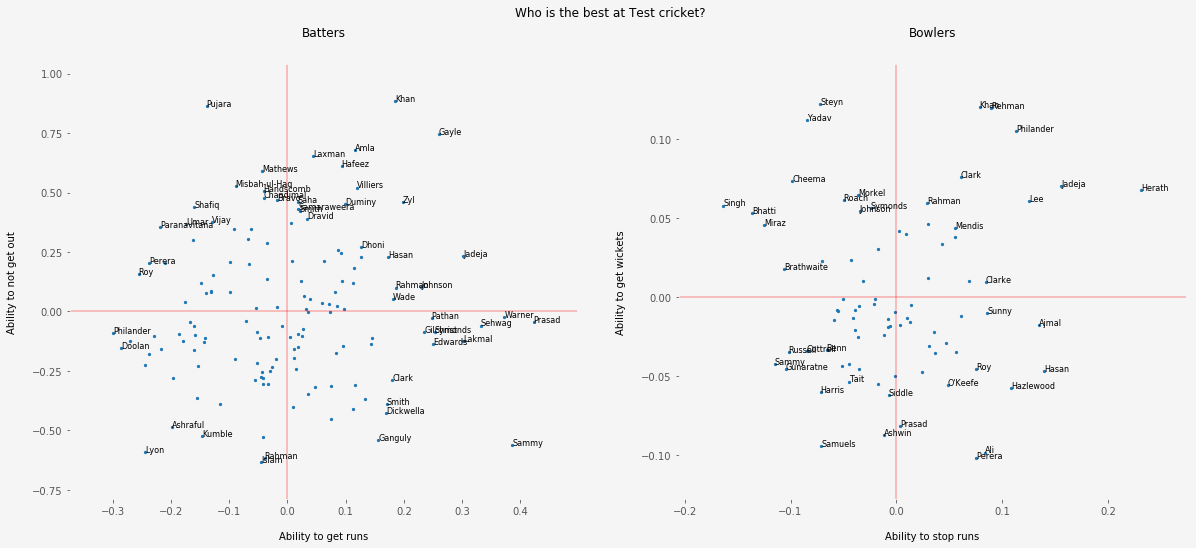

In [16]:
f, axes = plt.subplots(1, 2, figsize=[20, 8])
f.suptitle("Who is the best at Test cricket?")

axes[0].scatter(batters['run_mean'], batters['wicket_mean'], s=5)

for i, row in batters.sort_values('weirdness', ascending=False).iloc[:50].iterrows(): 
    axes[0].text(row['run_mean'], row['wicket_mean'], row['batter'].split(' ')[-1], fontsize=8)
    
axes[0].set_xlabel('Ability to get runs')
axes[0].set_ylabel('Ability to not get out')
axes[0].set_title('Batters')
axes[0].axvline(0, color='r', alpha=0.3)
axes[0].axhline(0, color='r', alpha=0.3)

axes[1].scatter(bowlers['run_mean'], bowlers['wicket_mean'], s=5)

for i, row in bowlers.sort_values('weirdness', ascending=False).iloc[:40].iterrows(): 
    axes[1].text(row['run_mean'], row['wicket_mean'], row['bowler'].split(' ')[-1], fontsize=8)
    
axes[1].set_xlabel('Ability to stop runs')
axes[1].set_ylabel('Ability to get wickets')
axes[1].set_title('Bowlers')
axes[1].axvline(0, color='r', alpha=0.3)
axes[1].axhline(0, color='r', alpha=0.3)

plt.show()

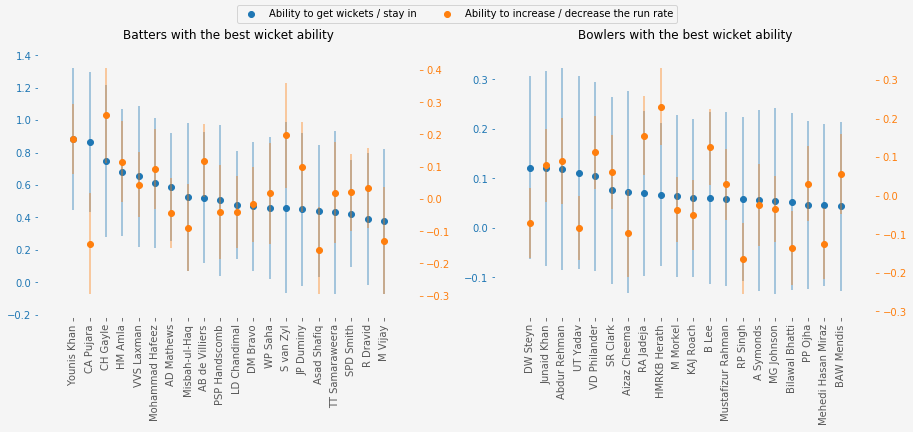

In [17]:
plt.style.use('fr_sparse')

f, axes = plt.subplots(1, 2, figsize=[15, 5])
axes = axes.ravel()

for players, ax, name in zip([batters, bowlers], axes, ['batter', 'bowler']):
    
    b = players.sort_values('wicket_mean', ascending=False).iloc[:20]
    x = np.linspace(0, 1, len(b))
    wicket_scatter = ax.scatter(x, b['wicket_mean'])
    ax.vlines(x, b['wicket_mean'] + b['wicket_std'], b['wicket_mean'] - b['wicket_std'], color='tab:blue', alpha=0.5)

    twinax = ax.twinx()
    run_scatter = twinax.scatter(x, b['run_mean'], color='tab:orange')
    twinax.vlines(x, b['run_mean'] + b['run_std'], b['run_mean'] - b['run_std'], color='tab:orange', alpha=0.5)

    ax.tick_params(axis='y', colors='tab:blue')
    twinax.tick_params(axis='y', colors='tab:orange')
    ax.xaxis.set_ticks(x)
    ax.set_xticklabels(b[name], rotation=90)
    ax.set_title(name.capitalize() + 's with the best wicket ability', y=0.92)
    
f.legend([wicket_scatter, run_scatter], ['Ability to get wickets / stay in', 'Ability to increase / decrease the run rate'], loc='upper center', ncol=2)
plt.show()

## Checking the model

These results all seem fairly reasonable, but we should probably check the model a bit more thoroughly. Fortunately the `samples` dataframe contains simulated posterior predictive samples for runs and wickets, which we can compare with the observed values to see if the model has any systematic biases.

To start with we make some histograms to see how well the overall distribution of wicket and run simulations match the observed distributions.

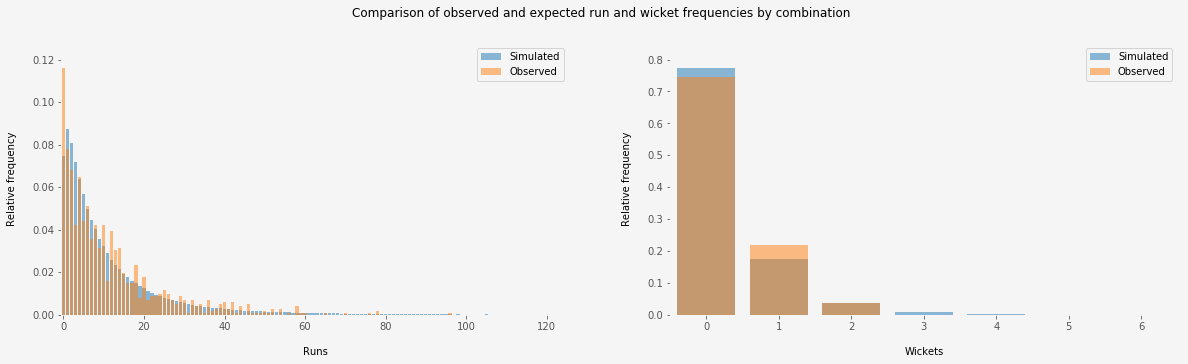

In [18]:
wicket_samples = util.get_parameter_samples('wickets_rep', samples)
run_samples = util.get_parameter_samples('runs_rep', samples)

f, axes = plt.subplots(1, 2, figsize=[20, 5])

f.suptitle("Comparison of observed and expected run and wicket frequencies by combination")

for ax, sample_df, name, xmax in zip(axes, [run_samples, wicket_samples], ['runs', 'wickets'], [125.5, 6.5]):

    sim_counts = sample_df.unstack().value_counts()
    obs_counts = summary[name].value_counts()
    sim_proportions = sim_counts / sim_counts.sum()
    obs_proportions = obs_counts / obs_counts.sum()

    ax.bar(sim_proportions.index, sim_proportions, alpha=0.5, label='Simulated')
    ax.bar(obs_proportions.index, obs_proportions, alpha=0.5, label='Observed')
    ax.set_xlabel(name.capitalize())
    ax.set_ylabel("Relative frequency")
    ax.set_xlim(-0.5, xmax)
    ax.legend()
plt.show()

Our simulations have proportionally fewer cases with zero runs than the observations and more cases with two and three runs. This is probably because the model doesn't know that twos and threes are pretty unusual compared to ones and fours. However for amounts of runs greater than four or five the distributions are quite well aligned. Perhaps we should consider a zero-inflated model next time.

The simulations have proportionally more cases with zero wickets than the observations, and fewer cases with one wicket. Perhaps this is because batters are more likely to get out when they first arrive at the crease compared to later on. Perhaps batters who get out to a bowler once are extra careful not to get caught out (no pun intended) in the same way for a second time.

Next we plot observed runs and wickets against number of balls for every combination, along with the simulated 50% and 90% probable intervals. This should give us an idea of whether the model is systematically going wrong in a way that depends on the total number of balls.

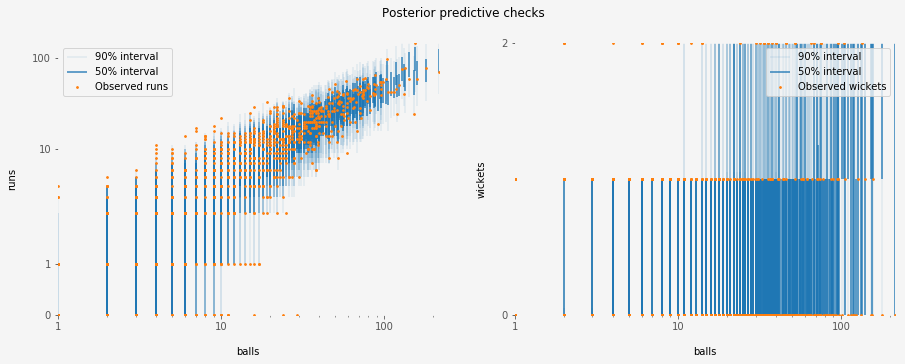

In [19]:
f, axes = plt.subplots(1, 2, figsize=[15, 5])
axes = axes.ravel()
f.suptitle("Posterior predictive checks")
for ax, posterior_samples, y_name in zip(axes, [run_samples, wicket_samples], ['runs', 'wickets']):
    x = summary['balls']
    y = summary[y_name]
    pct_5, pct_25, pct_75, pct_95 = (np.percentile(posterior_samples, i, axis=0)
                                     for i in [5, 25, 75, 95])
    
    ax.vlines(x, pct_5, pct_95, color='tab:blue', alpha=0.1, label='90% interval')
    ax.vlines(x, pct_25, pct_75, color='tab:blue', alpha=0.9, label='50% interval')
             
    ax.scatter(x, y, s=3, color='tab:orange', zorder=4, label='Observed ' + y_name)
    
    ax.set_xlabel('balls')
    ax.set_ylabel(y_name)
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('symlog')
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim(1, x.max())
    ax.set_ylim(0, y.max())

plt.show()

It looks like the proportion of observations outside the model's probable intervals is roughly correct for both wickets and runs. However there are 

In [20]:
run_pct_5, run_pct_25, run_pct_75, run_pct_95 = (np.percentile(run_samples, i, axis=0) for i in [5, 25, 75, 95])
wkt_pct_5, wkt_pct_25, wkt_pct_75, wkt_pct_95 = (np.percentile(wicket_samples, i, axis=0) for i in [5, 25, 75, 95])

As a final bit of posterior predictive checking we find the proportions of observed combinations fell outside the 50% and 90% probable intervals for both wickets and runs. Ideally these should be about 10% and 50% respectively.

In [21]:
for obs, lower, upper, interval in zip(['runs', 'runs', 'wickets', 'wickets'], 
                                       [run_pct_5, run_pct_25, wkt_pct_5, wkt_pct_25],
                                       [run_pct_95, run_pct_75, wkt_pct_95, wkt_pct_75],
                                       [90, 50, 90, 50]):
    proportion = ((summary[obs] < lower) | (summary[obs] > upper)).sum() / len(summary)
    print("Proportion of combinations with {0} outside the {1}% probable interval: {2}"
          .format(obs, interval, proportion))

Proportion of combinations with runs outside the 90% probable interval: 0.06496062992125984
Proportion of combinations with runs outside the 50% probable interval: 0.35531496062992124
Proportion of combinations with wickets outside the 90% probable interval: 0.05019685039370079
Proportion of combinations with wickets outside the 50% probable interval: 0.18110236220472442
